In [116]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# import lazypredict

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [117]:
df_ger = pd.read_csv('Data/China.csv',  index_col='Year')
df_ger # the one with categorical variable for Germany

,Country,ISO 3166-1 alpha-3,Total,Coal,Oil,Gas
Year,,,,,,
1950,China,CHN,78.835287,77.614512,0.619216,0.014656
1951,China,CHN,102.115213,100.133456,0.937984,0.007328
1952,China,CHN,127.999326,125.444368,1.337360,0.014656
1953,China,CHN,133.782883,130.236986,1.908892,0.021983
1954,China,CHN,160.877410,155.591889,3.341492,0.029311
...,...,...,...,...,...,...
2017,China,CHN,10011.107108,7163.317856,1430.586816,486.359360
2018,China,CHN,10353.876989,7316.399776,1500.473952,575.368912
2019,China,CHN,10740.996069,7543.157408,1559.728160,630.171360


In [118]:
# Drop the categorial variables
df= df_ger.select_dtypes(include=['float64'])
df

,Total,Coal,Oil,Gas
Year,,,,
1950,78.835287,77.614512,0.619216,0.014656
1951,102.115213,100.133456,0.937984,0.007328
1952,127.999326,125.444368,1.337360,0.014656
1953,133.782883,130.236986,1.908892,0.021983
1954,160.877410,155.591889,3.341492,0.029311
...,...,...,...,...
2017,10011.107108,7163.317856,1430.586816,486.359360
2018,10353.876989,7316.399776,1500.473952,575.368912
2019,10740.996069,7543.157408,1559.728160,630.171360


In [119]:
#  plot to see total emission versus year for 'Germany'
fig_ger = px.line(df, x=df.index, y="Total")
fig_ger.update_xaxes(rangeslider_visible=True)
fig_ger.show()

Visualize the time series

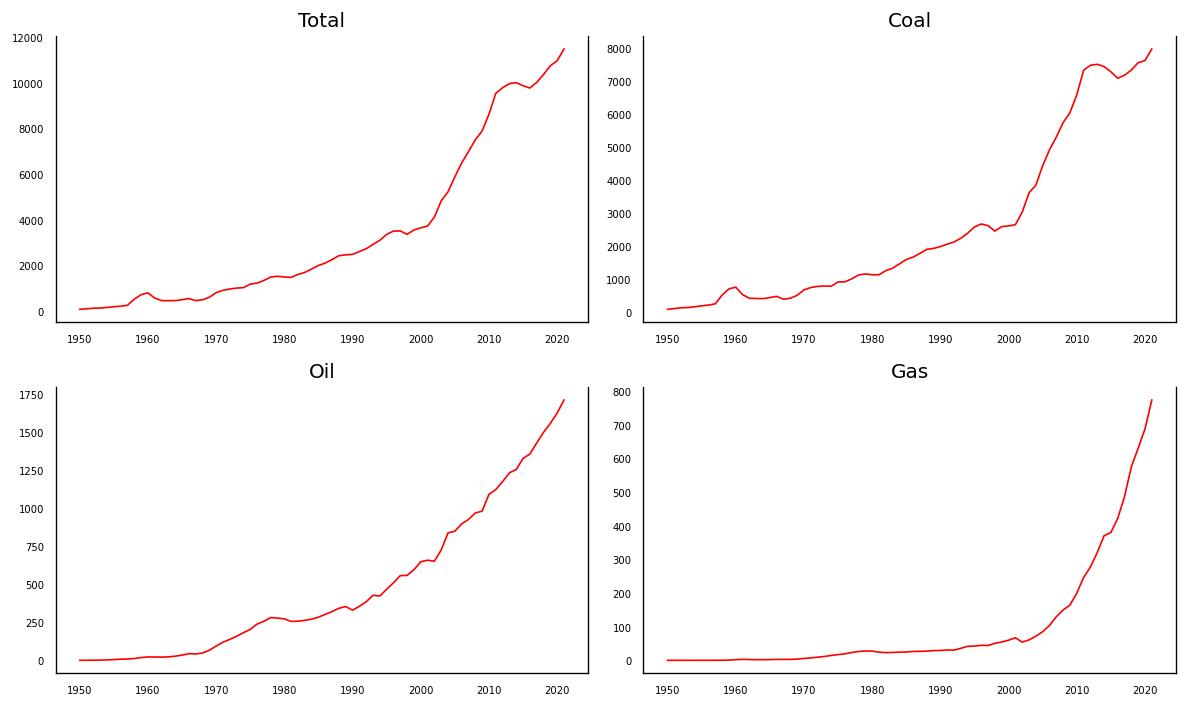

In [120]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

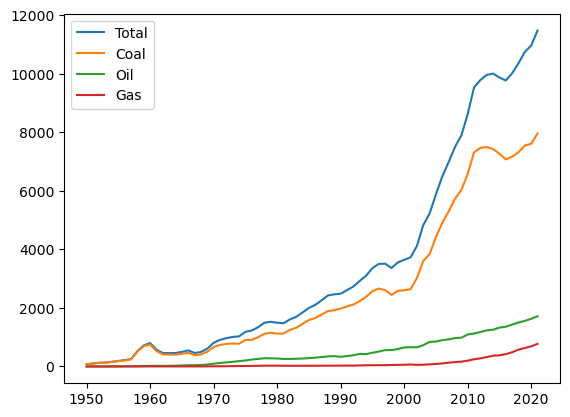

In [121]:
plt.figure()

x = df.index
y1 = df['Total']
y2 = df['Coal']
y3 = df['Oil']
y4 = df['Gas']






plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y4)




plt.legend(['Total', 'Coal', 'Oil', 'Gas'])

Grainger's Causality Test

In [122]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)   

,Total_x,Coal_x,Oil_x,Gas_x
Total_y,1.0,0.0,0.0,0.0000
Coal_y,0.0,1.0,0.0,0.0001
Oil_y,0.0,0.0,1.0,0.0006
Gas_y,0.0,0.0,0.0,1.0000


 Cointegration Test

In [123]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Total  ::  82.63     > 40.1749   =>   True
Coal   ::  30.84     > 24.2761   =>   True
Oil    ::  13.49     > 12.3212   =>   True
Gas    ::  0.25      > 4.1296    =>   False


Split the Series into Training and Testing Data

In [124]:
nobs = 5
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape) 

(67, 4)
(5, 4)


Check for Stationarity and Make the Time Series Stationary

In [125]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [126]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Total" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.945
 No. Lags Chosen       = 9
 Critical value 1%     = -3.551
 Critical value 5%     = -2.914
 Critical value 10%    = -2.595
 => P-Value = 0.9986. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Coal" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.0545
 No. Lags Chosen       = 1
 Critical value 1%     = -3.535
 Critical value 5%     = -2.907
 Critical value 10%    = -2.591
 => P-Value = 0.9538. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Oil" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root

In [127]:
# The ADF test confirms none of the time series is stationary. Let’s difference all of them once and check again.
# 1st difference
df_differenced = df_train.diff().dropna()

In [128]:
# Re-run ADF test on each differenced series.
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Total" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0097
 No. Lags Chosen       = 0
 Critical value 1%     = -3.535
 Critical value 5%     = -2.907
 Critical value 10%    = -2.591
 => P-Value = 0.034. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Coal" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.25
 No. Lags Chosen       = 0
 Critical value 1%     = -3.535
 Critical value 5%     = -2.907
 Critical value 10%    = -2.591
 => P-Value = 0.0173. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Oil" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

In [129]:
# Let’s difference all of them once more and check again.
# 2nd difference
df_differenced = df_differenced.diff().dropna()

In [130]:
# Re-run ADF test on each differenced series.
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')
    ### result: all the time series became stationary ###

    Augmented Dickey-Fuller Test on "Total" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.2712
 No. Lags Chosen       = 1
 Critical value 1%     = -3.539
 Critical value 5%     = -2.909
 Critical value 10%    = -2.592
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Coal" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.5277
 No. Lags Chosen       = 1
 Critical value 1%     = -3.539
 Critical value 5%     = -2.909
 Critical value 10%    = -2.592
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Oil" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


How to Select the Order (P) of VAR model

In [131]:
# To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.
# Though the usual practice is to look at the AIC, you can also check other best fit comparison estimates of BIC, FPE and HQIC.

model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  25.716071082905625
BIC :  26.390722046455522
FPE :  147537368392.21005
HQIC:  25.98185017580962 

Lag Order = 2
AIC :  25.28928347672417
BIC :  26.513931891805044
FPE :  96920280174.74574
HQIC:  25.770943684276922 

Lag Order = 3
AIC :  24.783114809302628
BIC :  26.567163003211416
FPE :  59447934510.04308
HQIC:  25.483577140191382 

Lag Order = 4
AIC :  24.49041250237605
BIC :  26.84351779358564
FPE :  45957416514.54343
HQIC:  25.412616518609397 

Lag Order = 5
AIC :  24.043618871622446
BIC :  26.975701258733388
FPE :  31308920872.760292
HQIC:  25.190517481623512 

Lag Order = 6
AIC :  23.47145976152831
BIC :  26.99270966645326
FPE :  19612919613.07865
HQIC:  24.84601311246259 

Lag Order = 7
AIC :  22.58487961567024
BIC :  26.705765636763076
FPE :  9545434080.376207
HQIC:  24.190047949906507 

Lag Order = 8
AIC :  21.821536114413124
BIC :  26.552812734661558
FPE :  5776018994.0436
HQIC:  23.660271433747738 

Lag Order = 9
AIC :  21.11390279808082
BIC :  26.4666179

In [132]:
# An alternate method to choose the order(p) of the VAR models is to use the model.select_order(maxlags) method.
#x = model.select_order(maxlags=6)
#x.summary()

We choose d = 3 as the number of lags (AIC and BIC is locally minimum at d=3)

Train the VAR Model of Selected Order(p)

In [133]:
p=3
model_fitted = model.fit(p)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Mar, 2023
Time:                     14:23:29
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    26.5672
Nobs:                     62.0000    HQIC:                   25.4836
Log likelihood:          -1068.17    FPE:                5.94479e+10
AIC:                      24.7831    Det(Omega_mle):     2.77625e+10
--------------------------------------------------------------------
Results for equation Total
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           17.053696        19.756018            0.863           0.388
L1.Total         0.450376         1.693224            0.266           0.790
L1.Coal         -0.503491         1.766368           -0.285           0.776
L1.O

Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic. Results close to 2 is alright.

In [134]:
from statsmodels.stats.stattools import durbin_watson

def adjust(val, length= 6): return str(val).ljust(length)
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

Total  : 1.93
Coal   : 1.93
Oil    : 1.73
Gas    : 1.95


How to Forecast VAR model using statsmodels

In [135]:
df_differenced

,Total,Coal,Oil,Gas
Year,,,,
1952,2.604187,2.791968,0.080608,0.014656
1953,-20.100556,-20.518294,0.172156,-0.000001
1954,21.310970,20.562285,0.861068,0.000001
1955,2.549524,2.249544,0.644964,-0.003663
1956,-4.341528,-5.777999,0.597156,0.010991
...,...,...,...,...
2012,-661.177155,-585.972528,21.566304,-14.795232
2013,-73.699229,-126.372215,5.056783,10.918840
2014,-134.713675,-97.035666,-36.926718,7.565920


In [136]:
# In order to forecast, the VAR model expects up to the lag order number of observations from the past data.
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input # the output is the values of total, coal, oil and gas for 2015 and 2016 (this depends on the train test split and lag_order)

3


array([[-134.713675,  -97.035666,  -36.926718,    7.56592 ],
       [-174.029915,  -89.700155,   52.21663 ,  -40.263432],
       [  29.792362,  -37.487257,  -44.167381,   31.843375]])

In [137]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs) # nobs is from test train split ratio
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Total_2d,Coal_2d,Oil_2d,Gas_2d
Year,,,,
2017,-28.223618,-60.345653,51.251770,-8.356520
2018,406.860464,504.048808,-34.094677,-21.961941
2019,-168.966113,-318.332270,51.593899,32.663232
2020,-179.287772,-100.787884,-47.601432,-10.738430
2021,413.299991,460.563788,7.654995,-15.748546


Invert the transformation to get the real forecast

In [138]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [139]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['Total_forecast', 'Coal_forecast', 'Oil_forecast','Gas_forecast']]

,Total_forecast,Coal_forecast,Oil_forecast,Gas_forecast
Year,,,,
2017,9634.831554,6815.482941,1438.121861,455.043750
2018,9911.543827,7063.610979,1484.311468,466.399319
2019,10019.289987,6993.406747,1582.094974,510.418120
2020,9947.748375,6822.414631,1632.277049,543.698492
2021,10289.506754,7111.986304,1690.114118,561.230318


In [140]:
df_test

,Total,Coal,Oil,Gas
Year,,,,
2017,10011.107108,7163.317856,1430.586816,486.359360
2018,10353.876989,7316.399776,1500.473952,575.368912
2019,10740.996069,7543.157408,1559.728160,630.171360
2020,10956.213369,7605.716883,1627.725238,687.880944
2021,11472.369171,7955.985419,1713.339980,773.866062


Plot of Forecast vs Actuals

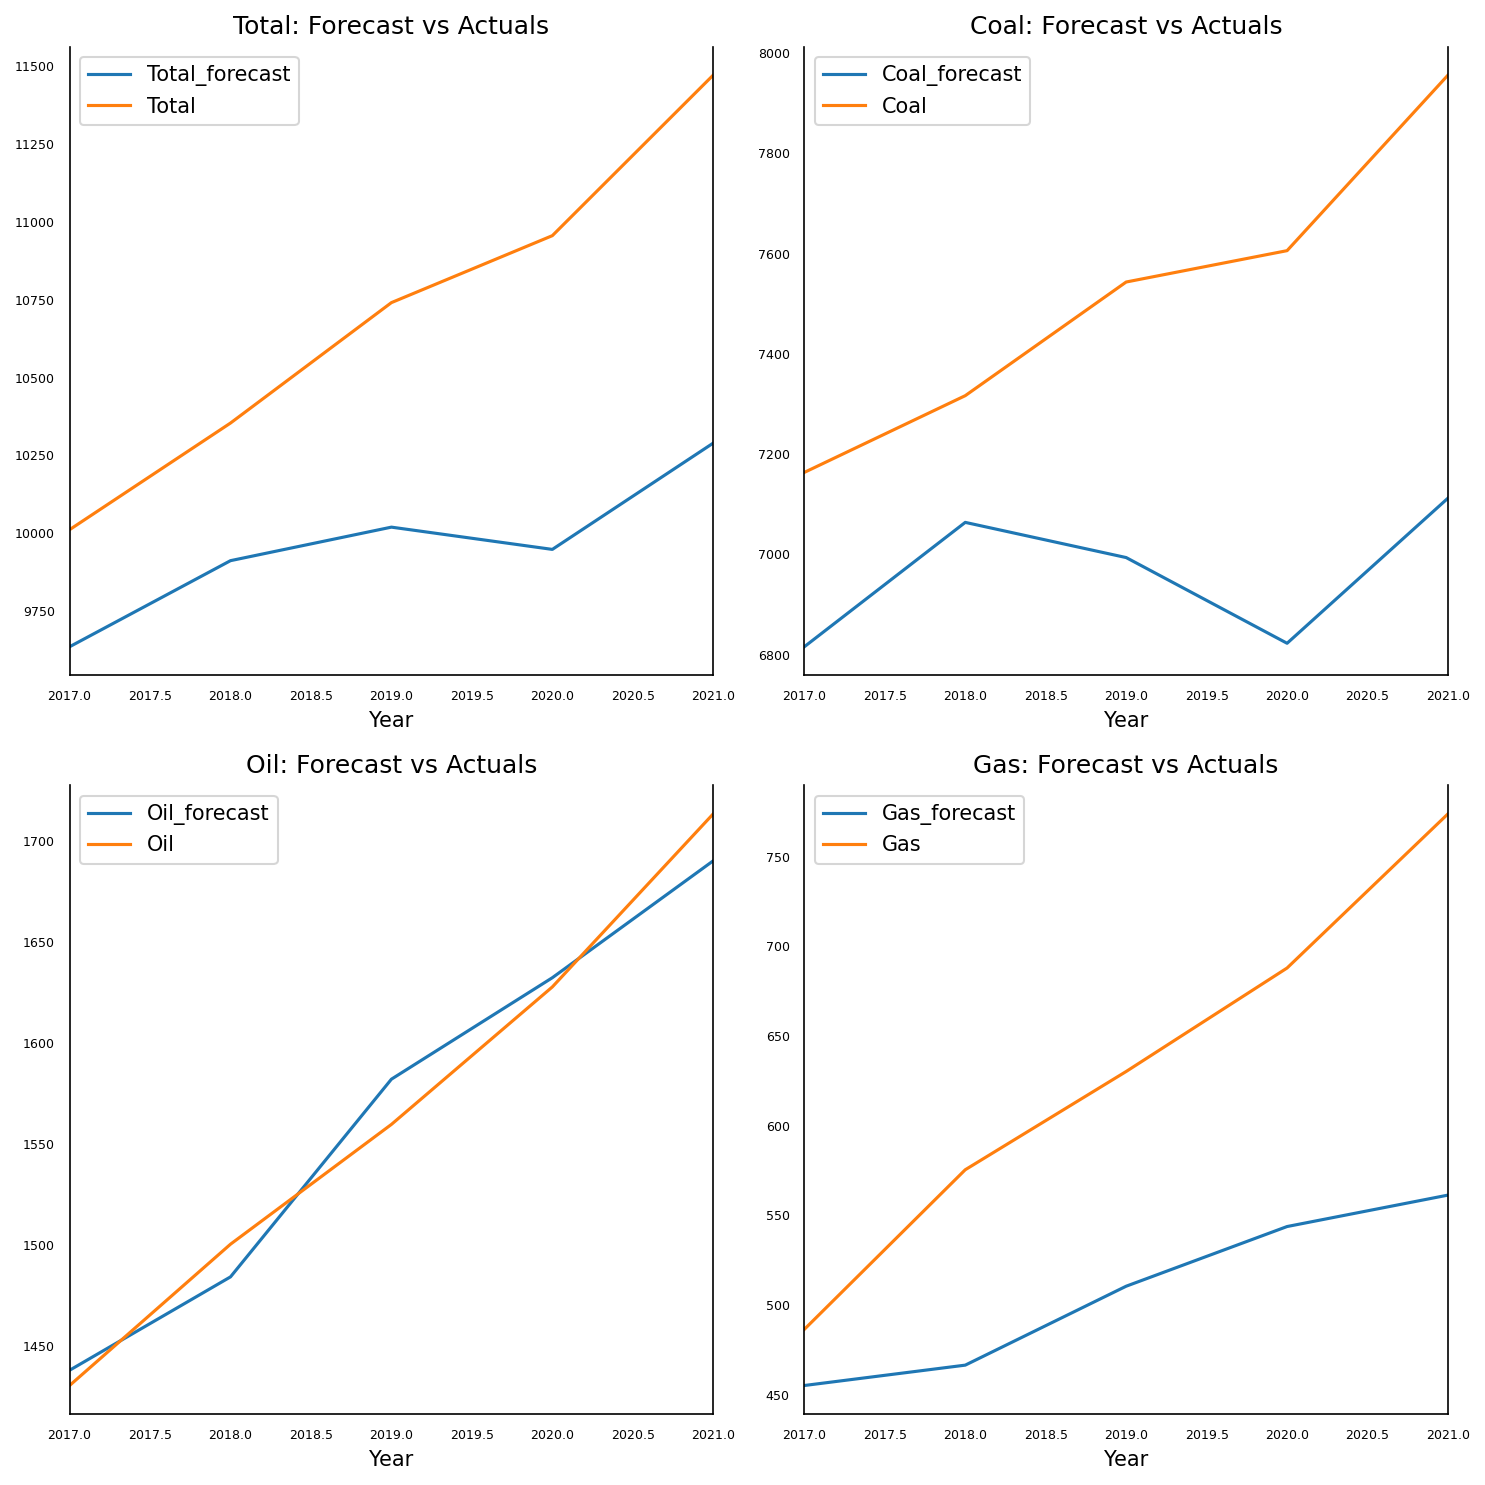

In [141]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Evaluate the Forecasts

In [142]:
# To evaluate the forecasts, let’s compute a comprehensive set of metrics, namely, the MAPE, ME, MAE, MPE, RMSE, corr and minmax.
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: Total')
accuracy_prod = forecast_accuracy(df_results['Total_forecast'].values, df_test['Total'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: Coal')
accuracy_prod = forecast_accuracy(df_results['Coal_forecast'].values, df_test['Coal'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: Oil')
accuracy_prod = forecast_accuracy(df_results['Oil_forecast'].values, df_test['Oil'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: Gas')
accuracy_prod = forecast_accuracy(df_results['Gas_forecast'].values, df_test['Gas'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: Total
mape   :  0.0685
me     :  -746.3284
mae    :  746.3284
mpe    :  -0.0685
rmse   :  809.2301
corr   :  0.9394
minmax :  0.0685

Forecast Accuracy of: Coal
mape   :  0.073
me     :  -555.5351
mae    :  555.5351
mpe    :  -0.073
rmse   :  602.1651
corr   :  0.5178
minmax :  0.073

Forecast Accuracy of: Oil
mape   :  0.0093
me     :  -0.9869
mae    :  14.7684
mpe    :  -0.0004
rmse   :  16.6038
corr   :  0.9865
minmax :  0.0093

Forecast Accuracy of: Gas
mape   :  0.1856
me     :  -123.3713
mae    :  123.3713
mpe    :  -0.1856
rmse   :  136.5272
corr   :  0.9658
minmax :  0.1856


Forecasting the future: for 2 years (since p=2)

In [143]:
df_differenced_all = df.diff().dropna()

In [144]:
df_differenced_all

,Total,Coal,Oil,Gas
Year,,,,
1951,23.279926,22.518944,0.318768,-0.007328
1952,25.884113,25.310912,0.399376,0.007328
1953,5.783557,4.792618,0.571532,0.007327
1954,27.094527,25.354903,1.432600,0.007328
1955,29.644051,27.604447,2.077564,0.003665
...,...,...,...,...
2017,246.127363,91.914145,72.749239,64.633121
2018,342.769881,153.081920,69.887136,89.009552
2019,387.119080,226.757632,59.254208,54.802448


In [145]:
forecast_input_all = df_differenced_all.values[-lag_order:]
forecast_input_all # the output is the values of total, coal, oil and gas for 2015 and 2016 (this depends on the train test split and lag_order)

array([[387.11908 , 226.757632,  59.254208,  54.802448],
       [215.2173  ,  62.559475,  67.997078,  57.709584],
       [516.155802, 350.268536,  85.614742,  85.985118]])

In [146]:
model_all = VAR(df_differenced_all)
model_fitted_all = model_all.fit(p)
model_fitted_all.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Mar, 2023
Time:                     14:23:30
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    27.6675
Nobs:                     68.0000    HQIC:                   26.6428
Log likelihood:          -1216.94    FPE:                1.93652e+11
AIC:                      25.9703    Det(Omega_mle):     9.61872e+10
--------------------------------------------------------------------
Results for equation Total
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           23.291581        30.464328            0.765           0.445
L1.Total         1.057925         1.658785            0.638           0.524
L1.Coal         -0.334773         1.757779           -0.190           0.849
L1.O

In [147]:
# Forecast

l = df_differenced_all.last_valid_index() # gives the index of the last row in df_differenced_all
s = 10 # steps to future
fc_all = model_fitted_all.forecast(y=forecast_input_all, steps=s) 
df_forecast_all = pd.DataFrame(fc_all, index=list(range(l+1,l+s+1)), columns=df.columns + '_2d')
df_forecast_all

,Total_2d,Coal_2d,Oil_2d,Gas_2d
2022,438.780675,242.737156,50.092408,89.490445
2023,214.004372,30.134757,72.684836,81.945351
2024,379.268765,177.112677,87.161423,99.758122
2025,387.861037,163.191479,79.529981,107.054017
2026,287.139609,63.430773,88.003310,106.457174
2027,360.014651,118.808949,99.036843,119.270439
2028,404.996471,139.376009,101.012547,130.628362
2029,374.205541,98.311654,106.430975,136.315495
2030,404.240777,110.919933,116.087009,147.373518
2031,444.844911,126.444852,122.650935,160.437916


In [148]:
# Tranforming the future forecast back
df_results_all = invert_transformation(df, df_forecast_all, second_diff=True) 
df_results_all = df_results_all.loc[:, ['Total_forecast', 'Coal_forecast', 'Oil_forecast','Gas_forecast']]

In [149]:
df_results_all

,Total_forecast,Coal_forecast,Oil_forecast,Gas_forecast
2022,12427.305648,8548.991111,1849.047130,949.341625
2023,13596.246497,9172.131559,2057.439116,1206.762539
2024,15144.456111,9972.384685,2352.992525,1563.941574
2025,17080.526762,10935.829289,2728.075916,2028.174626
2026,19303.737022,11962.704666,3191.162616,2598.864852
2027,21886.961933,13108.388992,3753.286159,3288.825517
2028,24875.183315,14393.449328,4416.422250,4109.414544
2029,28237.610239,15776.821317,5185.989315,5066.319066
2030,32004.277938,17271.113240,6071.643389,6170.597105
2031,36215.790549,18891.850015,7079.948399,7435.313061


In [150]:
# Concate the actual df with the forecasted df till 2031 (df_results_all)

df_results_all = df_results_all.rename(columns={"Total_forecast": "Total", "Coal_forecast": "Coal", "Oil_forecast": "Oil", "Gas_forecast": "Gas"})
# renaming the df_results_all columns to that of df

df_results_all

,Total,Coal,Oil,Gas
2022,12427.305648,8548.991111,1849.047130,949.341625
2023,13596.246497,9172.131559,2057.439116,1206.762539
2024,15144.456111,9972.384685,2352.992525,1563.941574
2025,17080.526762,10935.829289,2728.075916,2028.174626
2026,19303.737022,11962.704666,3191.162616,2598.864852
2027,21886.961933,13108.388992,3753.286159,3288.825517
2028,24875.183315,14393.449328,4416.422250,4109.414544
2029,28237.610239,15776.821317,5185.989315,5066.319066
2030,32004.277938,17271.113240,6071.643389,6170.597105
2031,36215.790549,18891.850015,7079.948399,7435.313061


In [151]:
# Concat syntax
df_future  = pd.concat([df, df_results_all], axis=0)
df_future

,Total,Coal,Oil,Gas
1950,78.835287,77.614512,0.619216,0.014656
1951,102.115213,100.133456,0.937984,0.007328
1952,127.999326,125.444368,1.337360,0.014656
1953,133.782883,130.236986,1.908892,0.021983
1954,160.877410,155.591889,3.341492,0.029311
...,...,...,...,...
2027,21886.961933,13108.388992,3753.286159,3288.825517
2028,24875.183315,14393.449328,4416.422250,4109.414544
2029,28237.610239,15776.821317,5185.989315,5066.319066
2030,32004.277938,17271.113240,6071.643389,6170.597105


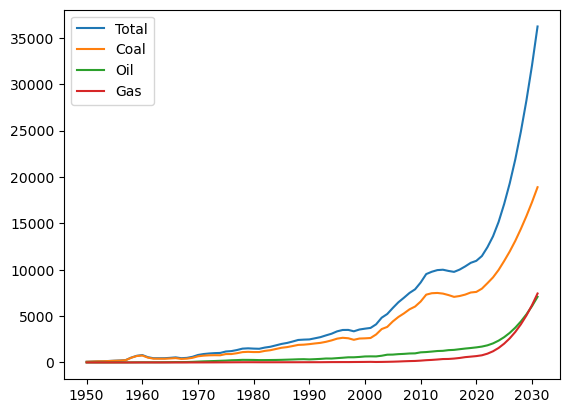

In [152]:
# Plot
plt.figure()

x = df_future.index
y1 = df_future['Total']
y2 = df_future['Coal']
y3 = df_future['Oil']
y4 = df_future['Gas']

plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y4)

plt.legend(['Total', 'Coal', 'Oil', 'Gas'])

In [153]:
df_future["Year"]=df_future.index
df_future

,Total,Coal,Oil,Gas,Year
1950,78.835287,77.614512,0.619216,0.014656,1950
1951,102.115213,100.133456,0.937984,0.007328,1951
1952,127.999326,125.444368,1.337360,0.014656,1952
1953,133.782883,130.236986,1.908892,0.021983,1953
1954,160.877410,155.591889,3.341492,0.029311,1954
...,...,...,...,...,...
2027,21886.961933,13108.388992,3753.286159,3288.825517,2027
2028,24875.183315,14393.449328,4416.422250,4109.414544,2028
2029,28237.610239,15776.821317,5185.989315,5066.319066,2029
2030,32004.277938,17271.113240,6071.643389,6170.597105,2030


In [154]:
# save to csv
df_future.to_csv('Data/Germany_future.csv', index=False)